In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,random_split
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [2]:
dataset = torchvision.datasets.CIFAR10(root='data/',download=True,transform=transforms.Compose([
    transforms.RandomCrop(32, padding=4,padding_mode='reflect'), # augmentation
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(), # CxHxW
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
]))

test_dataset = torchvision.datasets.CIFAR10(root='data/',train = False,download=True,transform=transforms.Compose([
    transforms.RandomCrop(32, padding=4,padding_mode='reflect'), # augmentation
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(), # CxHxW
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
]))

Files already downloaded and verified
Files already downloaded and verified


In [3]:
val_ratio = 0.2
train_dataset, val_dataset = random_split(dataset,[int((1-val_ratio)*len(dataset)), int(val_ratio*len(dataset))])
batch_size =  32 #higher batch size is better
train_dl = DataLoader(train_dataset,batch_size,shuffle=True,pin_memory=True)
val_dl = DataLoader(val_dataset,batch_size,shuffle=True,pin_memory=True)
test_dl = DataLoader(test_dataset,batch_size,pin_memory=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


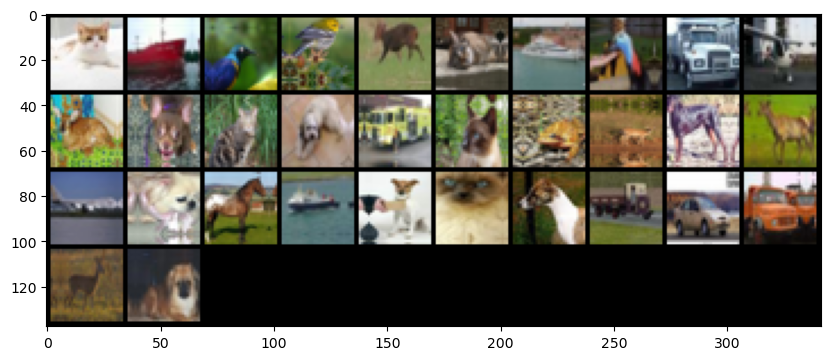

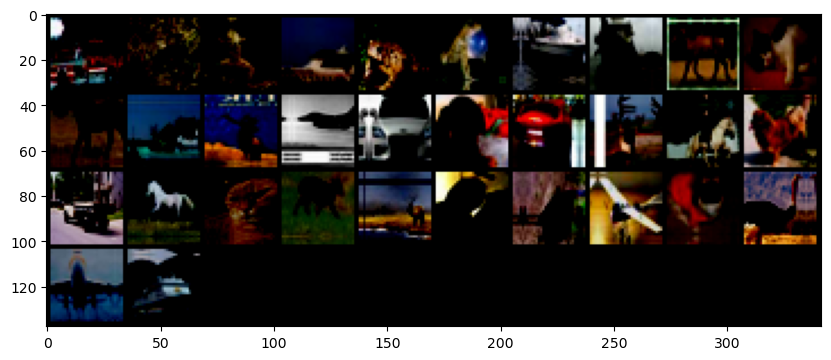

In [4]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

def denormalize(images,means,std_div):
  means = torch.tensor(means).reshape(1,3,1,1)
  std_div = torch.tensor(std_div).reshape(1,3,1,1)
  return images*std_div + means

def show_preview(dl,normalized):
  for images,labels in dl:
    fig, ax = plt.subplots(figsize=(10,10))
    if(normalized):
      images = denormalize(images,(0.5,0.5,0.5),(0.5,0.5,0.5))
    ax.imshow(make_grid(images,10).permute(1,2,0)) #H,W,C
    break
show_preview(train_dl,1)
show_preview(train_dl,0)

In [5]:
def get_default_devices():
  return torch.device("cuda").type if torch.cuda.is_available() else torch.device("cpu")

def to_device(data,device):
  if(isinstance(data,(list,tuple))):
    return [to_device(x,device) for x in data]
  return data.to(device,non_blocking=True)
  #non blocking means you dont want to block execution of code when transferring code

class DeviceDataLoader():
  ''' wrapper around dataloaders to transfer batches to specified devices'''
  def __init__(self,dl,device):
    self.dl = dl
    self.device = device
  def __iter__(self):
    for b in self.dl:
      yield to_device(b,self.device)
  def __len__(self):
    return len(self.dl)

device = get_default_devices()
train_dl = DeviceDataLoader(train_dl,device)
test_dl = DeviceDataLoader(test_dl,device)
val_dl = DeviceDataLoader(val_dl,device)

In [85]:
class CustomCNN(nn.Module):
    def __init__(self, input_size, conv_layers, output_size):
        super(CustomCNN, self).__init__()

        self.conv_layers = nn.ModuleList()
        in_channels = 3

        self.current_size = input_size
        self.intermediate_sizes = []

        for (out_channels, kernel_size, stride, padding, pooling_kernel, pooling_stride) in conv_layers:
            # Add convolutional layer
            conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=padding)
            self.conv_layers.append(conv)
            self.conv_layers.append(nn.BatchNorm2d(out_channels))
            self.conv_layers.append(nn.ReLU())
            
            # Add pooling layer
            self.conv_layers.append(nn.MaxPool2d(kernel_size=pooling_kernel, stride=pooling_stride))

            # Update the size calculations
            self.current_size = (self.current_size - kernel_size + 2 * padding) // stride + 1
            self.current_size = (self.current_size - pooling_kernel) // pooling_stride + 1
            self.intermediate_sizes.append((out_channels, self.current_size, self.current_size))
            in_channels = out_channels

        # Create a 1x1 convolution layer for each intermediate output
        self.final_convolutions = nn.ModuleList()
        for (out_channels, height, width) in self.intermediate_sizes:
            self.final_convolutions.append(nn.Conv2d(out_channels, 1, kernel_size=1))

        final_feature_size = sum(1 * h * w for _, h, w in self.intermediate_sizes)
        self.fc_out = nn.Linear(final_feature_size, output_size)

    def forward(self, x):
        intermediate_outputs = []

        for i, layer in enumerate(self.conv_layers):
            x = layer(x)
            if i % 4 == 3:  # Adjusted for batch norm, ReLU, pooling
                # Apply the corresponding 1x1 convolution to reduce channels to 1
                index = len(intermediate_outputs)
                intermediate_output = self.final_convolutions[index](x)
                intermediate_outputs.append(intermediate_output.view(intermediate_output.size(0), -1))

        # Concatenate along the channel dimension
        concatenated = torch.cat(intermediate_outputs, dim=1)
        x = self.fc_out(concatenated)
        return x


In [91]:
IP = 32
conv_layers = [
    # op channels, kernel size, stride, padding, pooling kernel, pooling stride
    (32, 3, 1, 1, 2, 2),   # More output channels from the start
    (64, 3, 1, 1, 2, 2),
    (128, 3, 1, 1, 2, 2),
    (256, 3, 1, 1, 2, 2),  # Larger feature map before pooling
]
OP = 10
max_lr = 1e-2
epochs = 300
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD

In [92]:
model = CustomCNN(input_size=IP, conv_layers=conv_layers, output_size=OP).to(device)

In [93]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [94]:
def accuracy(output, labels):
    predClassId = torch.argmax(output, dim=1)
    return (predClassId == labels).float().mean().item()

def evaluate(model, dl, loss_func):
    model.eval()
    with torch.no_grad():
        batch_losses, batch_accs = [], []

        for images, labels in dl:
            out = model(images)
            loss = loss_func(out, labels)
            batch_losses.append(loss)

            # Calculate accuracy
            acc = accuracy(out, labels)
            batch_accs.append(acc)

        val_loss = torch.stack(batch_losses).mean().item()
        val_acc = torch.tensor(batch_accs).mean().item()
        return val_loss, val_acc

def train(model, train_dl, val_dl, epochs, max_lr, loss_function, optimizer_class):
    model.to(device)  # Move model to the appropriate device
    optimizer = optimizer_class(model.parameters(), lr=max_lr, momentum=0.9, weight_decay=5e-4)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)
    early_stopper = EarlyStopper(patience=5, min_delta=0.001)

    results = []

    for epoch in range(epochs):
        model.train()
        train_loss = []
        lrs = []

        for images, labels in train_dl:  # for every batch
            optimizer.zero_grad()
            out = model(images)
            loss = loss_function(out, labels)
            train_loss.append(loss)
            loss.backward()  # delta loss/delta_model_parameters
            optimizer.step()
            lrs.append(optimizer.param_groups[0]['lr'])
        
        scheduler.step()

        epoch_train_loss = torch.stack(train_loss).mean().item()

        # Evaluate on validation data
        val_loss, val_acc = evaluate(model, val_dl, loss_function)
        if early_stopper.early_stop(val_loss):
            break

        # Store results
        results.append({'avg_train_loss': epoch_train_loss, 'avg_val_loss': val_loss, 'avg_val_acc': val_acc, 'lrs': lrs})
        if (epoch + 1) % 20 == 0:
            torch.save(model.state_dict(), 'model.pth')  # Overwrite the same file
            print(f'Model saved after epoch {epoch + 1}')

        # Print progress for each epoch
        print(f"Epoch [{epoch+1}/{epochs}]")
        print(f"Training Loss: {epoch_train_loss:.4f}")
        print(f"Validation Loss: {val_loss:.4f}")
        print(f"Validation Accuracy: {val_acc:.4f}\n")

    return results

In [ ]:
results = train(model, train_dl, val_dl, epochs, max_lr, loss_func, optimizer)

Epoch [1/300]
Training Loss: 1.5641
Validation Loss: 1.3141
Validation Accuracy: 0.5246

Epoch [2/300]
Training Loss: 1.2488
Validation Loss: 1.1123
Validation Accuracy: 0.5998

Epoch [3/300]
Training Loss: 1.1254
Validation Loss: 1.0409
Validation Accuracy: 0.6277

Epoch [4/300]
Training Loss: 1.0386
Validation Loss: 0.9431
Validation Accuracy: 0.6631

Epoch [5/300]
Training Loss: 0.9662
Validation Loss: 0.9414
Validation Accuracy: 0.6656

Epoch [6/300]
Training Loss: 0.9175
Validation Loss: 0.9393
Validation Accuracy: 0.6666

Epoch [7/300]
Training Loss: 0.8768
Validation Loss: 0.8831
Validation Accuracy: 0.6966

Epoch [8/300]
Training Loss: 0.8508
Validation Loss: 0.8466
Validation Accuracy: 0.7056

Epoch [9/300]
Training Loss: 0.8261
Validation Loss: 0.8442
Validation Accuracy: 0.7066

Epoch [10/300]
Training Loss: 0.8071
Validation Loss: 0.8285
Validation Accuracy: 0.7114

Epoch [11/300]
Training Loss: 0.7852
Validation Loss: 0.8339
Validation Accuracy: 0.7120

Epoch [12/300]
Trai